# **Sentiment Analysis of Tweets on Twitter**

In recent years, social media platforms like Twitter have become vital sources of public opinion. Analyzing the sentiments expressed in tweets can provide insights into public perceptions on various topics, such as politics, products, or social issues. This project aims to perform sentiment analysis on tweets identifying whether the sentiments expressed are positive, negative.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import  train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
  data = pd.read_csv('/gdrive/MyDrive/Tweets.csv')

In [ ]:
# We only take tweets that we are very confident about

data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['sentiment'] = data_clean['airline_sentiment'].\
    apply(lambda x: 1 if x=='negative' else 0)

data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

In [ ]:
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x=='negative' else 0)

In [ ]:
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]

In [ ]:
data_clean.head()

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1


In [ ]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [ ]:
import nltk
nltk.download('stopwords')

def tokenize(text):
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english"))

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


 We will now apply cross-validation methods and grid search to find the best hyperparameter

In [ ]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer,
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]},
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,
                    n_jobs=-1)

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.9188979138877743

In [ ]:
grid_svm.best_score_

0.9025857063886015

In [ ]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [ ]:
#  Let's now observe the performance (with the best hyperparameter of our model) on the test set .
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.8337605272793849,
 'auc': 0.9189027336468586,
 'f1': 0.8690888119953863,
 'precision': 0.9133333333333333,
 'recall': 0.828932893289329}

Above, we observe that the model generalizes with an accuracy of 83%

In [ ]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [ ]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

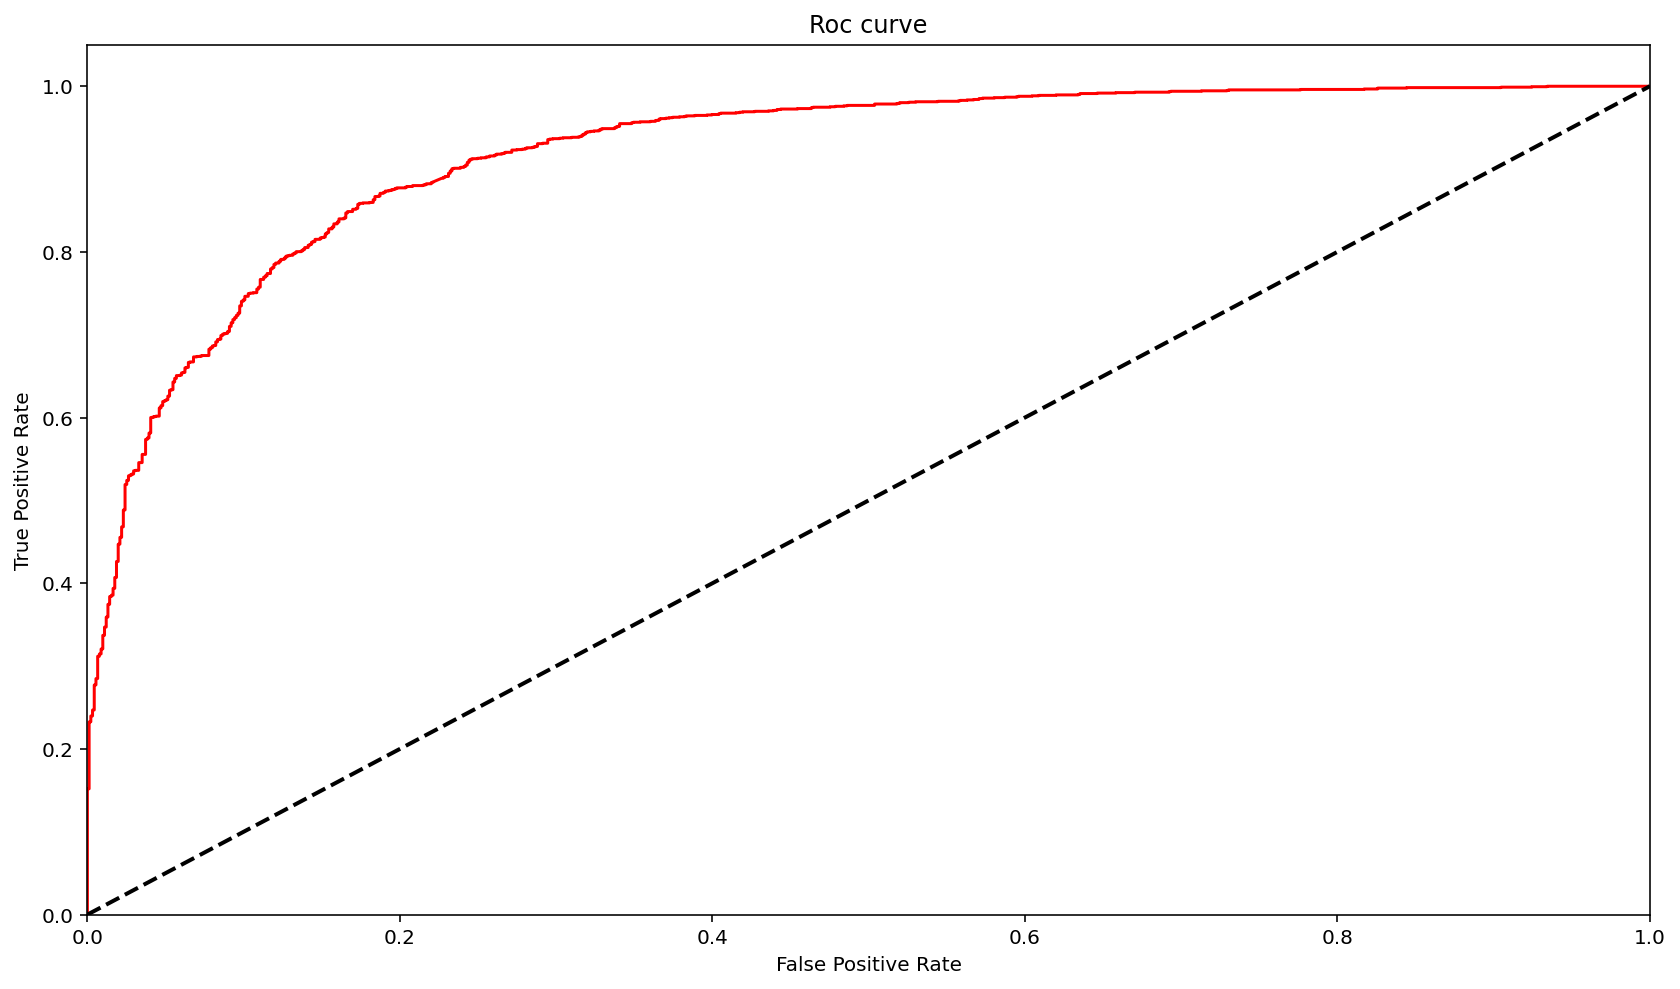

In [ ]:
# Construction de la courbe Roc
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1,
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [ ]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

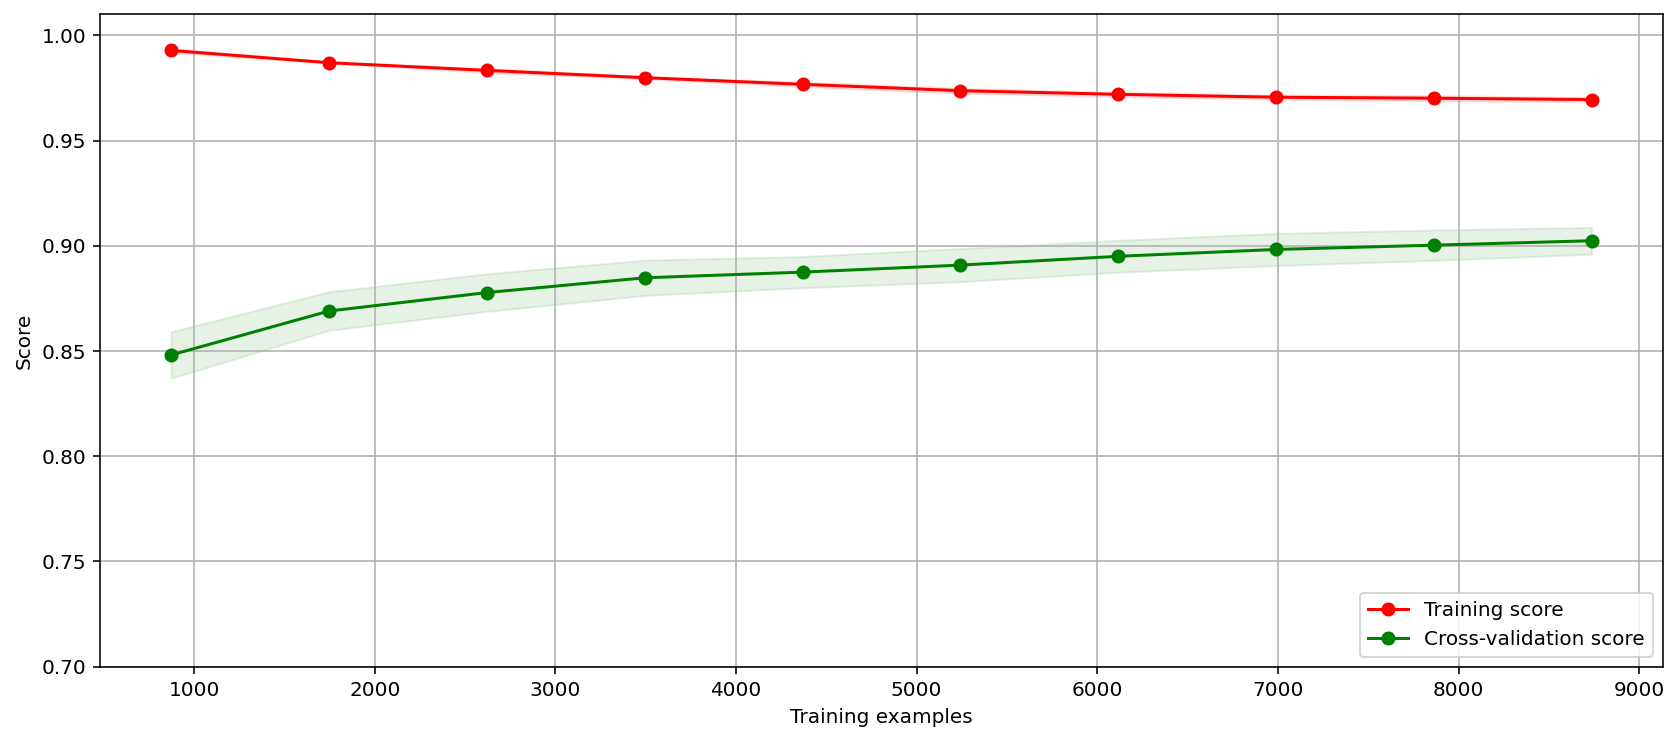

In [ ]:
plot_learning_curve(X_train, y_train, train_sizes,
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

we can make some test now

In [ ]:
 grid_svm.predict(["flying with @united is always a great experience"])

array([0])

In [ ]:
grid_svm.predict(["flying with @united is always a great experience. If you don't lose your luggage"])

array([1])

In [ ]:
grid_svm.predict(["I love @united. Sorry, just kidding!"])

array([0])